Background:

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.


Data Description:
Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

Goal(s):

Predict if a customer is happy or not based on the answers they give to questions asked.

Success Metrics:

Reach 73% accuracy score or above, or convince us why your solution is superior. We are definitely interested in every solution and insight you can provide us.

Try to submit your working solution as soon as possible. The sooner the better.

Bonus(es):

We are very interested in finding which questions/features are more important when predicting a customer’s happiness. Using a feature selection approach show us understand what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have. Is there any question that we can remove in our next survey?



In [1]:
# import modules
import random
import os
import warnings
# ignore warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Import scikit-learn tools, grid search cross validation, and classifiers

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix,\
roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV,GridSearchCV

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegression

# import pipeline and scaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import randint, uniform
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

# import Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

# import stacking classifier
from sklearn.ensemble import StackingClassifier

from sklearn.neighbors import KNeighborsClassifier

# import lazy predict
import lazypredict
from lazypredict.Supervised import LazyClassifier


## Create a function to set global seed

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed) 
    os.environ['PYTHONHASHSEED']=str(seed)
    print(seed)


## Pick a value for the seed, and provide to the function

In [3]:
seed = 477
set_seed(seed)
print('Seed_value has been set to ' + str(seed))

477
Seed_value has been set to 477


In [4]:
# load the dataset
customer_data = pd.read_csv('ACME-HappinessSurvey2020.csv')
customer_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [5]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


## SHIFT the scale from 1-5 such that 3 becomes 0 at the center

In [6]:
customer_data['X1'] = customer_data['X1'] - 3
customer_data['X2'] = customer_data['X2'] - 3
customer_data['X3'] = customer_data['X3'] - 3
customer_data['X4'] = customer_data['X4'] - 3
customer_data['X5'] = customer_data['X5'] - 3
customer_data['X6'] = customer_data['X6'] - 3

In [7]:
# rename the columns
customer_data = customer_data.rename(columns = {'Y': 'Happy', 'X1':'DeliveredOnTime', 'X2':'ContentsCorrect', 'X3':'I ordered everything', 'X4': 'GoodPrice', 'X5':'CourierSatisfaction', 'X6': 'AppEasyOrdering'})
#ADDING A NEW FEATURE 'AVG' below
column_list = ['DeliveredOnTime', 'ContentsCorrect', 'I ordered everything', 'GoodPrice', 'CourierSatisfaction', 'AppEasyOrdering']
customer_data['AvgSurvey'] = customer_data[column_list].mean(axis=1)
##ADDING A NEW FEATURE 'AVG' above
customer_data.head()

,Happy,DeliveredOnTime,ContentsCorrect,I ordered everything,GoodPrice,CourierSatisfaction,AppEasyOrdering,AvgSurvey
0,0,0,0,0,1,-1,1,0.17
1,0,0,-1,0,2,1,0,0.33
2,1,2,0,0,0,0,2,0.67
3,0,2,1,0,0,0,2,0.83
4,0,2,1,0,0,0,2,0.83


In [8]:
customer_data.describe()

,Happy,DeliveredOnTime,ContentsCorrect,I ordered everything,GoodPrice,CourierSatisfaction,AppEasyOrdering,AvgSurvey
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,1.33,-0.47,0.31,0.75,0.65,1.25,0.64
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81,0.57
min,0.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-1.17
25%,0.00,1.00,-1.00,0.00,0.00,0.00,1.00,0.33
50%,1.00,2.00,0.00,0.00,1.00,1.00,1.00,0.67
75%,1.00,2.00,0.00,1.00,1.00,1.00,2.00,1.00
max,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00


In [9]:
# checking for duplicate data
customer_data.duplicated().sum()

16

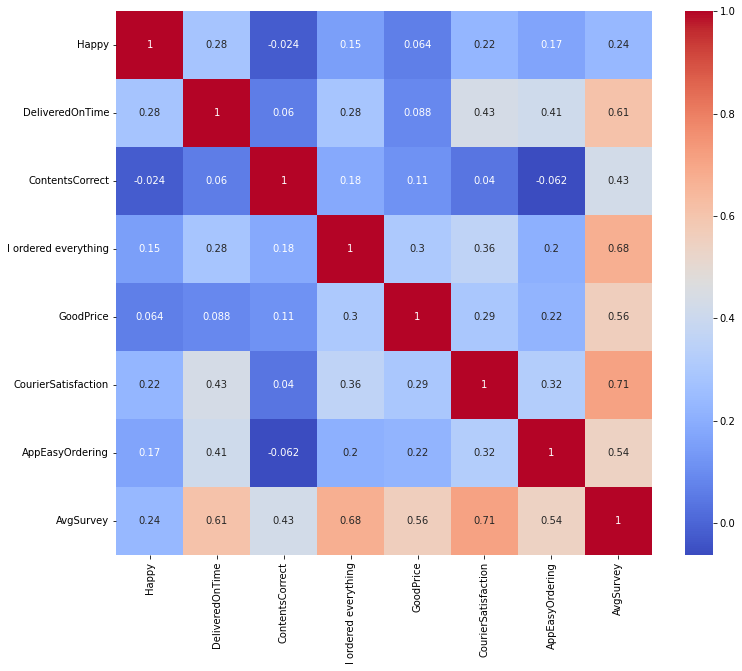

In [10]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = customer_data.corr()
sns.heatmap(cor, annot=True, cmap="coolwarm")
plt.show()

In [11]:
# Correlation with output variable
cor_target = cor["Happy"]
# Selecting highly positively correlated features
cor_target

Happy                   1.00
DeliveredOnTime         0.28
ContentsCorrect        -0.02
I ordered everything    0.15
GoodPrice               0.06
CourierSatisfaction     0.22
AppEasyOrdering         0.17
AvgSurvey               0.24
Name: Happy, dtype: float64

In [12]:
# Correlation with output variable
cor_Courier = cor["CourierSatisfaction"]
# Selecting highly positively correlated features
cor_Courier

Happy                  0.22
DeliveredOnTime        0.43
ContentsCorrect        0.04
I ordered everything   0.36
GoodPrice              0.29
CourierSatisfaction    1.00
AppEasyOrdering        0.32
AvgSurvey              0.71
Name: CourierSatisfaction, dtype: float64

## Exploratory Data Analysis led to shifting the data to be centered around 0 instead of 3. In additon to plotting the feature response frequencies, the SUM of all features seems to reveal an inflection point. In order to include it as an additonal feature, we can scale it by using the Average instead of the Sum.

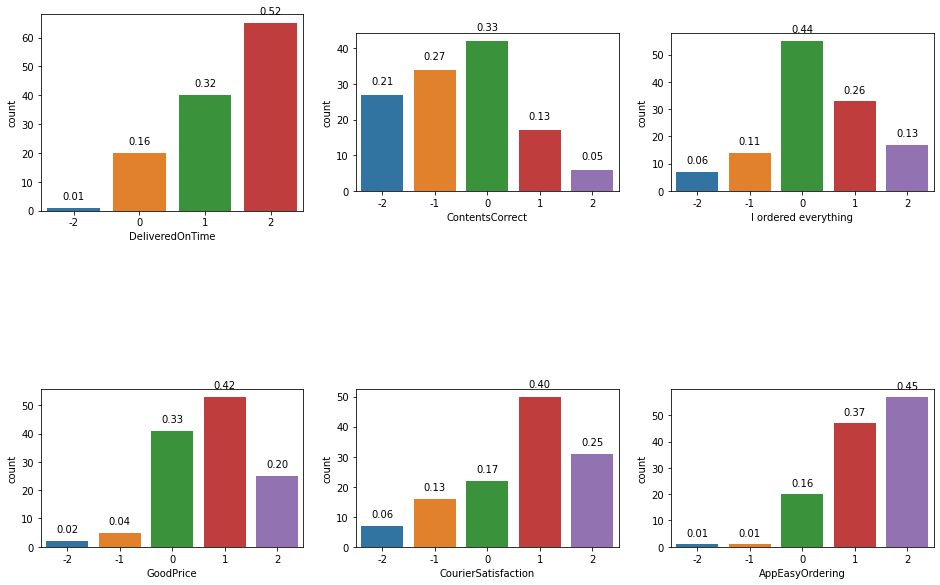

In [13]:
# Create a function for distribution plot
def count_plot(column_name, dataset, x=0, y=0):
    ax = sns.countplot(x=column_name, data= dataset, ax = axes[x, y])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(dataset))),
            ha="center")
        ax.set_box_aspect(3/len(ax.patches))
        
# Distribution of other variables
fig, axes =plt.subplots(2,3, figsize=(16, 12))
count_plot('DeliveredOnTime', customer_data, x = 0, y= 0)
count_plot('ContentsCorrect', customer_data, x = 0, y= 1)
count_plot('I ordered everything', customer_data, x = 0, y= 2)
count_plot('GoodPrice', customer_data, x = 1, y= 0)
count_plot('CourierSatisfaction', customer_data, x = 1, y= 1)
count_plot('AppEasyOrdering', customer_data, x = 1, y= 2)

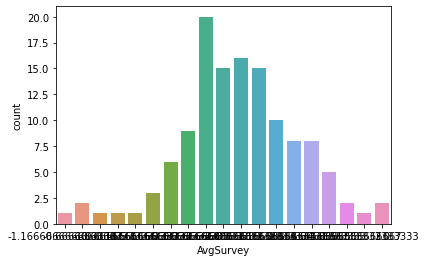

In [14]:
ax = sns.countplot(x="AvgSurvey", data=customer_data)

## Set the train, test, split test size (after experimenting with different test size values). Also use the seed value as defined in order to set it globally. 

In [15]:
#set predictor variables and target variables
X = customer_data.drop(columns= ['Happy'])
y = customer_data.Happy

In [16]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 100
X Testing set sample size: 26
y Training set sample size: 100
y Testing set sample size: 26


In [17]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    y_test_pred_proba = model.predict_proba(X_test)[:,1]
    
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)
    roc= roc_auc_score(y_test, y_test_pred_proba)

    print("TRAINIG RESULTS: \n===============================")
    print(f"RECALL SCORE:{recall_score(y_train, y_train_pred):.4f}")
    print(f"ACCURACY SCORE:{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print()
    print()

    print("TESTING RESULTS: \n===============================")
    print(f"RECALL SCORE:{recall_score(y_test, y_test_pred):.4f}")
    print(f"ACCURACY SCORE:{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    
    print('F1-score: ' , round(f1,4))
#    print("Best Score: " , round(model.best_score_,4))
    print("Test ROC AUC:", round(roc,4), '\n')
#    print("Best Parameters: " , model.best_params_)
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label= 'f"{model}" ')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Model selection tool LazyPredict will help identify candidates for the most appropriate model

In [18]:
%%time
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 34.12it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SGDClassifier                      0.81               0.80     0.80      0.81   
DecisionTreeClassifier             0.77               0.77     0.77      0.77   
ExtraTreesClassifier               0.73               0.73     0.73      0.73   
PassiveAggressiveClassifier        0.73               0.73     0.73      0.73   
QuadraticDiscriminantAnalysis      0.73               0.71     0.71      0.72   
Perceptron                         0.69               0.70     0.70      0.69   
RandomForestClassifier             0.69               0.70     0.70      0.69   
BaggingClassifier                  0.69               0.70     0.70      0.69   
LGBMClassifier                     0.69               0.68     0.68      0.69   
BernoulliNB                        0.65               0.67     0.67      0.65   
XGBClassifier               

In [19]:
%%time
#Run Random Forest Classifier with default settings, before scaling and tuning 
rc = RandomForestClassifier()

rc.fit(X_train, y_train)

rc_predict = rc.predict(X_test)

#print (confusion_matrix(y_test , rc_predict))
#print ("Accuracy score: ", accuracy_score(y_test , rc_predict))
#print("F1 score: ", f1_score(y_test , rc_predict))
#print("Precision score: " , precision_score(y_test , rc_predict))
#print("Recall score: " , recall_score(y_test , rc_predict))
#print (classification_report(y_test , rc_predict))
rc

CPU times: user 594 ms, sys: 22.6 ms, total: 617 ms
Wall time: 254 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### This is the default RandomForest model with no standard scaling, but manually shifted to be centered around zero. Not only does it makes sense, but it improves both test and train scores.

#### Also no feature selection yet, but includes new feature "Average". This is a high scoring result, even better than some initial tweaking. 


TRAINIG RESULTS: 
RECALL SCORE:0.9825
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[38  5]
 [ 1 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.97  0.92      0.94       0.95          0.94
recall     0.88  0.98      0.94       0.93          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.7500
ACCURACY SCORE:0.6923
CONFUSION MATRIX:
[[9 5]
 [3 9]]
F1-score:  0.6923
Test ROC AUC: 0.8393 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.75  0.64      0.69       0.70          0.70
recall     0.64  0.75      0.69       0.70          0.69
f1-score   0.69  0.69      0.69       0.69          0.69
support   14.00 12.00      0.69      26.00         26.00


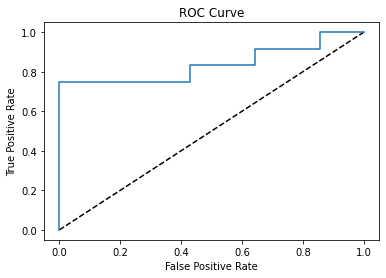

In [20]:
evaluate(rc, X_train, X_test, y_train, y_test)

In [21]:
%%time
#lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr = LogisticRegression()

lr.fit(X_train, y_train)

lr_predict = lr.predict(X_test)

#print (confusion_matrix(y_test , lr_predict))
#print ("Accuracy score: ", accuracy_score(y_test , lr_predict))
#print("F1 score: ", f1_score(y_test , lr_predict))
#print("Precision score: " , precision_score(y_test , lr_predict))
#print("Recall score: " , recall_score(y_test , lr_predict))
#print (classification_report(y_test , lr_predict))
lr

CPU times: user 9.85 ms, sys: 2.59 ms, total: 12.4 ms
Wall time: 11.1 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

TRAINIG RESULTS: 
RECALL SCORE:0.7895
ACCURACY SCORE:0.5900
CONFUSION MATRIX:
[[14 29]
 [12 45]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.54  0.61      0.59       0.57          0.58
recall     0.33  0.79      0.59       0.56          0.59
f1-score   0.41  0.69      0.59       0.55          0.57
support   43.00 57.00      0.59     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.8333
ACCURACY SCORE:0.6154
CONFUSION MATRIX:
[[ 6  8]
 [ 2 10]]
F1-score:  0.6667
Test ROC AUC: 0.7857 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.75  0.56      0.62       0.65          0.66
recall     0.43  0.83      0.62       0.63          0.62
f1-score   0.55  0.67      0.62       0.61          0.60
support   14.00 12.00      0.62      26.00         26.00


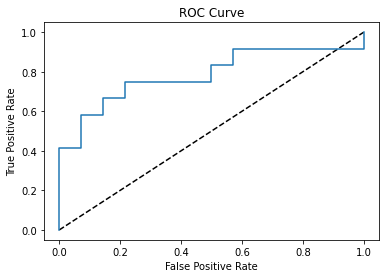

In [22]:
evaluate(lr, X_train, X_test, y_train, y_test)

## Note the 'rfc__random_state' parameter is supposed to used the seed, but it displays 'None' in the Gridsearch paramter listing, even though the tuned regression random_state parameter uses the global seed value we defined. Regardless, testing showed that the seed is enabling the ability to reproduce these results.

In [23]:
print(seed)

477


In [24]:
%%time
# RUN THE PIPELINE WITH DEFAULT PARAMETERS BEFORE USING STANDARD SCALER
# Setup the pipeline
steps = [
         ('rfc', RandomForestClassifier(n_estimators=100))
         ]

#steps = [('scaler', StandardScaler()),
#         ('rfc', RandomForestClassifier(n_estimators=10))
#         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__max_depth': [None],
                'rfc__class_weight': [None],
                'rfc__criterion' : ['gini'],
                'rfc__random_state' : [seed]}


# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned GridsearchCV Parameter: {}".format(rfc.best_params_))
print("Tuned GridsearchCV Accuracy: {}".format(rfc.best_score_))

rfc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Tuned GridsearchCV Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__random_state': 477}
Tuned GridsearchCV Accuracy: 0.45
CPU times: user 260 ms, sys: 90.1 ms, total: 350 ms
Wall time: 2.89 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                              

### Check the pipleline results using default parameters to baseline. Check this more carefully later for an explanation. A difference was observed for using the pipleline with same parameters in scenarios, with and with Avg and shifting.

TRAINIG RESULTS: 
RECALL SCORE:0.9825
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[38  5]
 [ 1 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.97  0.92      0.94       0.95          0.94
recall     0.88  0.98      0.94       0.93          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.7500
ACCURACY SCORE:0.6923
CONFUSION MATRIX:
[[9 5]
 [3 9]]
F1-score:  0.6923
Test ROC AUC: 0.8393 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.75  0.64      0.69       0.70          0.70
recall     0.64  0.75      0.69       0.70          0.69
f1-score   0.69  0.69      0.69       0.69          0.69
support   14.00 12.00      0.69      26.00         26.00


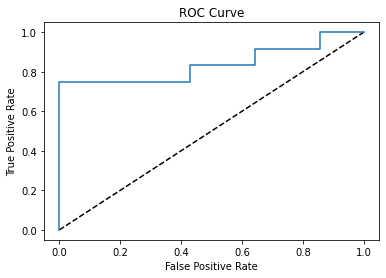

In [25]:
evaluate(rfc, X_train, X_test, y_train, y_test)

In [26]:
%%time
# using STANDARD SCALER
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier(n_estimators=100))
         ]

#steps = [('scaler', StandardScaler()),
#         ('rfc', RandomForestClassifier(n_estimators=10))
#         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__max_depth': [None],
                'rfc__class_weight': [None],
                 'rfc__criterion' : ['gini'],
                 'rfc__random_state' : [seed]}



# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned GridsearchCV Parameter: {}".format(rfc.best_params_))
print("Tuned GridsearchCV Accuracy: {}".format(rfc.best_score_))

rfc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Tuned GridsearchCV Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__random_state': 477}
Tuned GridsearchCV Accuracy: 0.45999999999999996
CPU times: user 210 ms, sys: 6.61 ms, total: 217 ms
Wall time: 755 ms


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                              

### Adding StandardScaler to the pipeline impacts the result. The results vary with different feature sets, so it is inconculsive whether it should be used. It will be easy to run a test to remove this from the final model.

TRAINIG RESULTS: 
RECALL SCORE:0.9825
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[38  5]
 [ 1 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.97  0.92      0.94       0.95          0.94
recall     0.88  0.98      0.94       0.93          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.7500
ACCURACY SCORE:0.6923
CONFUSION MATRIX:
[[9 5]
 [3 9]]
F1-score:  0.6923
Test ROC AUC: 0.8393 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.75  0.64      0.69       0.70          0.70
recall     0.64  0.75      0.69       0.70          0.69
f1-score   0.69  0.69      0.69       0.69          0.69
support   14.00 12.00      0.69      26.00         26.00


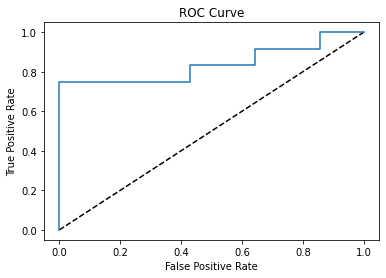

In [27]:
evaluate(rfc, X_train, X_test, y_train, y_test)

In [28]:
df_cols = customer_data[:0]
df_cols = df_cols.drop(['Happy'], axis = 1 )
df_cols.columns

Index(['DeliveredOnTime', 'ContentsCorrect', 'I ordered everything',
       'GoodPrice', 'CourierSatisfaction', 'AppEasyOrdering', 'AvgSurvey'],
      dtype='object')

<AxesSubplot:>

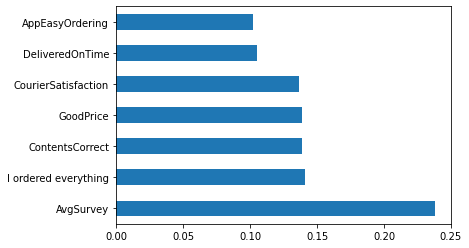

In [29]:
feat_importances = pd.Series(rfc.best_estimator_.named_steps['rfc'].feature_importances_,index=df_cols.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [30]:
for item1,item2 in sorted(zip(rfc.best_estimator_.named_steps['rfc'].feature_importances_,df_cols.columns),reverse=True):
    print(f'{item2} has a score of {item1}')

AvgSurvey has a score of 0.23813199304238913
I ordered everything has a score of 0.14106890692325394
ContentsCorrect has a score of 0.13872018610417716
GoodPrice has a score of 0.138437611156748
CourierSatisfaction has a score of 0.13681508992825908
DeliveredOnTime has a score of 0.10483223092449291
AppEasyOrdering has a score of 0.10199398192067972


In [31]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train, y_train) 
# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances

,importance
AvgSurvey,0.23
I ordered everything,0.15
GoodPrice,0.15
ContentsCorrect,0.14
CourierSatisfaction,0.13
DeliveredOnTime,0.11
AppEasyOrdering,0.10


## SHAP Analysis of feature importance

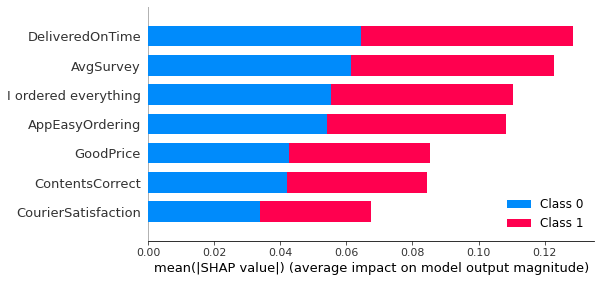

In [32]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

## The SHAP feature impact results are not necessarily consistent with pandas feature importance or RFE rankings. This is another reason to be cautious about removing features just to improve model performance.

### Recursive Feature Elimination - Check Rank values 1 thru 5



In [33]:
# feature extraction, Random Forest

rfe = RFE(rf, 5)
fit = rfe.fit(X_train, y_train)
selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':fit.ranking_})
selected_features.sort_values(by='Ranking')

,Feature,Ranking
1,ContentsCorrect,1
2,I ordered everything,1
3,GoodPrice,1
4,CourierSatisfaction,1
6,AvgSurvey,1
0,DeliveredOnTime,2
5,AppEasyOrdering,3


In [34]:
rfe = RFE(rf, 4)
fit = rfe.fit(X_train, y_train)
selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':fit.ranking_})
selected_features.sort_values(by='Ranking')

,Feature,Ranking
1,ContentsCorrect,1
3,GoodPrice,1
4,CourierSatisfaction,1
6,AvgSurvey,1
2,I ordered everything,2
0,DeliveredOnTime,3
5,AppEasyOrdering,4


In [35]:
rfe = RFE(rf, 3)
fit = rfe.fit(X_train, y_train)
selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':fit.ranking_})
selected_features.sort_values(by='Ranking')

,Feature,Ranking
1,ContentsCorrect,1
3,GoodPrice,1
6,AvgSurvey,1
2,I ordered everything,2
4,CourierSatisfaction,3
0,DeliveredOnTime,4
5,AppEasyOrdering,5


In [36]:
rfe = RFE(rf, 2)
fit = rfe.fit(X_train, y_train)
selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':fit.ranking_})
selected_features.sort_values(by='Ranking')

,Feature,Ranking
1,ContentsCorrect,1
6,AvgSurvey,1
3,GoodPrice,2
4,CourierSatisfaction,3
2,I ordered everything,4
0,DeliveredOnTime,5
5,AppEasyOrdering,6


In [37]:
rfe = RFE(rf, 1)
fit = rfe.fit(X_train, y_train)
selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':fit.ranking_})
selected_features.sort_values(by='Ranking')

,Feature,Ranking
6,AvgSurvey,1
1,ContentsCorrect,2
4,CourierSatisfaction,3
3,GoodPrice,4
2,I ordered everything,5
0,DeliveredOnTime,6
5,AppEasyOrdering,7


In [38]:
# drop the 'easy_ordering_app' feature from train and test set
X_train_rfe = X_train.drop(columns=['AppEasyOrdering'])
X_test_rfe = X_test.drop(columns=['AppEasyOrdering'])

In [39]:
rfc.fit(X_train_rfe, y_train)

rfc_predict = rfc.predict(X_test_rfe)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


### After removing the lowest ranked feature, the improvement is not conclusive compared to the default model without adjustments. Removing a second feature is also inconclusive.  

TRAINIG RESULTS: 
RECALL SCORE:0.9825
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[38  5]
 [ 1 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.97  0.92      0.94       0.95          0.94
recall     0.88  0.98      0.94       0.93          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.5833
ACCURACY SCORE:0.6538
CONFUSION MATRIX:
[[10  4]
 [ 5  7]]
F1-score:  0.6087
Test ROC AUC: 0.8095 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.67  0.64      0.65       0.65          0.65
recall     0.71  0.58      0.65       0.65          0.65
f1-score   0.69  0.61      0.65       0.65          0.65
support   14.00 12.00      0.65      26.00         26.00


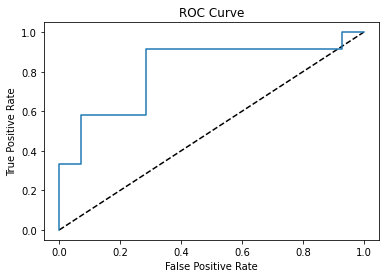

In [40]:
evaluate(rfc, X_train_rfe, X_test_rfe, y_train, y_test)

In [41]:
feature_importances = pd.DataFrame(rfc.best_estimator_.named_steps["rfc"].feature_importances_,
                                   index = X_train_rfe.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances

,importance
AvgSurvey,0.27
ContentsCorrect,0.17
CourierSatisfaction,0.15
I ordered everything,0.15
GoodPrice,0.15
DeliveredOnTime,0.12


In [42]:
# drop the 'easy_ordering_app' feature from train and test set
X_train_rfe = X_train.drop(columns=['AppEasyOrdering','I ordered everything'])
X_test_rfe = X_test.drop(columns=['AppEasyOrdering','I ordered everything'])

In [43]:
rfc.fit(X_train_rfe, y_train)

rfc_predict = rfc.predict(X_test_rfe)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


TRAINIG RESULTS: 
RECALL SCORE:0.9825
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[38  5]
 [ 1 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.97  0.92      0.94       0.95          0.94
recall     0.88  0.98      0.94       0.93          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.8333
ACCURACY SCORE:0.7692
CONFUSION MATRIX:
[[10  4]
 [ 2 10]]
F1-score:  0.7692
Test ROC AUC: 0.8095 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.83  0.71      0.77       0.77          0.78
recall     0.71  0.83      0.77       0.77          0.77
f1-score   0.77  0.77      0.77       0.77          0.77
support   14.00 12.00      0.77      26.00         26.00


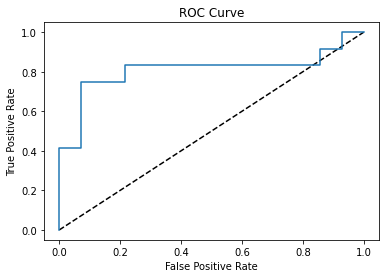

In [44]:
evaluate(rfc, X_train_rfe, X_test_rfe, y_train, y_test)

In [45]:
feature_importances = pd.DataFrame(rfc.best_estimator_.named_steps["rfc"].feature_importances_,
                                   index = X_train_rfe.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances

,importance
AvgSurvey,0.34
ContentsCorrect,0.20
CourierSatisfaction,0.18
GoodPrice,0.17
DeliveredOnTime,0.12


In [46]:
%%time
# RUN THE PIPELINE WITH DEFAULT PARAMETERS BEFORE USING STANDARD SCALER
# Setup the pipeline
steps = [
         ('rfc', RandomForestClassifier(n_estimators=100))
         ]

#steps = [('scaler', StandardScaler()),
#         ('rfc', RandomForestClassifier(n_estimators=10))
#         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__max_depth': [None],
                'rfc__class_weight': [None],
                 'rfc__criterion' : ['gini'],
                 'rfc__random_state' : [seed]}

# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned GridsearchCV Parameter: {}".format(rfc.best_params_))
print("Tuned GridsearchCV Accuracy: {}".format(rfc.best_score_))

rfc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Tuned GridsearchCV Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__random_state': 477}
Tuned GridsearchCV Accuracy: 0.45
CPU times: user 206 ms, sys: 7.21 ms, total: 213 ms
Wall time: 732 ms


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                              

In [47]:
# drop the 'easy_ordering_app' feature from train and test set
X_train_rfe = X_train.drop(columns=['AppEasyOrdering'])
X_test_rfe = X_test.drop(columns=['AppEasyOrdering'])

In [48]:
rfc.fit(X_train_rfe, y_train)

rfc_predict = rfc.predict(X_test_rfe)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


TRAINIG RESULTS: 
RECALL SCORE:0.9825
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[38  5]
 [ 1 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.97  0.92      0.94       0.95          0.94
recall     0.88  0.98      0.94       0.93          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.5833
ACCURACY SCORE:0.6923
CONFUSION MATRIX:
[[11  3]
 [ 5  7]]
F1-score:  0.6364
Test ROC AUC: 0.8155 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.69  0.70      0.69       0.69          0.69
recall     0.79  0.58      0.69       0.68          0.69
f1-score   0.73  0.64      0.69       0.68          0.69
support   14.00 12.00      0.69      26.00         26.00


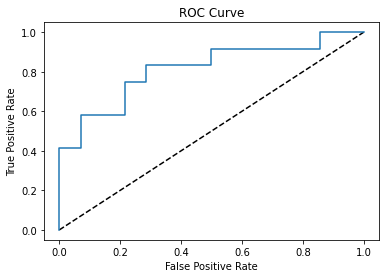

In [49]:
evaluate(rfc, X_train_rfe, X_test_rfe, y_train, y_test)

In [50]:
# drop the 'easy_ordering_app' feature from train and test set
X_train_rfe = X_train.drop(columns=['AppEasyOrdering','GoodPrice'])
X_test_rfe = X_test.drop(columns=['AppEasyOrdering','GoodPrice'])

In [51]:
rfc.fit(X_train_rfe, y_train)

rfc_predict = rfc.predict(X_test_rfe)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


TRAINIG RESULTS: 
RECALL SCORE:0.9649
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[39  4]
 [ 2 55]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.95  0.93      0.94       0.94          0.94
recall     0.91  0.96      0.94       0.94          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.5833
ACCURACY SCORE:0.8077
CONFUSION MATRIX:
[[14  0]
 [ 5  7]]
F1-score:  0.7368
Test ROC AUC: 0.7708 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.74  1.00      0.81       0.87          0.86
recall     1.00  0.58      0.81       0.79          0.81
f1-score   0.85  0.74      0.81       0.79          0.80
support   14.00 12.00      0.81      26.00         26.00


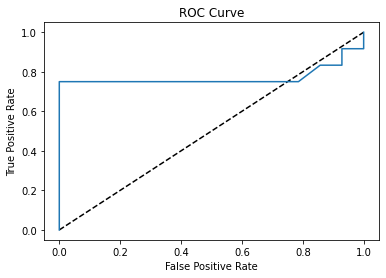

In [52]:
evaluate(rfc, X_train_rfe, X_test_rfe, y_train, y_test)

## Restore the full set of features plus Avg, before MODEL TUNING

In [53]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 100
X Testing set sample size: 26
y Training set sample size: 100
y Testing set sample size: 26


In [54]:
%%time
# using STANDARD SCALER
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier(n_estimators=100))
         ]

#steps = [('scaler', StandardScaler()),
#         ('rfc', RandomForestClassifier(n_estimators=10))
#         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__max_depth': [None],
                'rfc__class_weight': [None],
                 'rfc__criterion' : ['gini'],
                 'rfc__random_state' : [seed]}



# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned GridsearchCV Parameter: {}".format(rfc.best_params_))
print("Tuned GridsearchCV Accuracy: {}".format(rfc.best_score_))

rfc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Tuned GridsearchCV Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__random_state': 477}
Tuned GridsearchCV Accuracy: 0.45999999999999996
CPU times: user 207 ms, sys: 9.08 ms, total: 216 ms
Wall time: 775 ms


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                              

TRAINIG RESULTS: 
RECALL SCORE:0.9825
ACCURACY SCORE:0.9400
CONFUSION MATRIX:
[[38  5]
 [ 1 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.97  0.92      0.94       0.95          0.94
recall     0.88  0.98      0.94       0.93          0.94
f1-score   0.93  0.95      0.94       0.94          0.94
support   43.00 57.00      0.94     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.7500
ACCURACY SCORE:0.6923
CONFUSION MATRIX:
[[9 5]
 [3 9]]
F1-score:  0.6923
Test ROC AUC: 0.8393 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.75  0.64      0.69       0.70          0.70
recall     0.64  0.75      0.69       0.70          0.69
f1-score   0.69  0.69      0.69       0.69          0.69
support   14.00 12.00      0.69      26.00         26.00


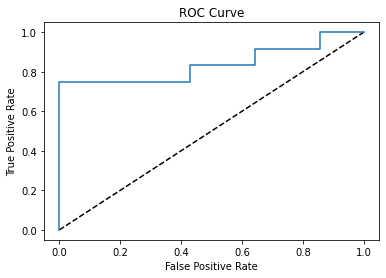

In [55]:
evaluate(rfc, X_train, X_test, y_train, y_test)

## Use GridSearchCV to evaluate different parameter values. Using the selected parameters has a positive impact on RECALL for the TEST SET, which looks promising despite some variability in training set. This type of result indicates an improvement in model fit. To recap, the final model includes the Average as an additonal feature and does not remove any orginal features. The survey results are shifted to be centered around 0, so scores includes negative numbers. Standard scaler is used in combination with Gridsearch to improve model performance.

In [56]:
%%time
# using STANDARD SCALER
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier(n_estimators=100))
         ]

#steps = [('scaler', StandardScaler()),
#         ('rfc', RandomForestClassifier(n_estimators=10))
#         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__max_depth': [1, 10, 20, 30, 50, None],
                'rfc__class_weight': [None, 'balanced'],
                 'rfc__criterion' : ['gini', 'entropy'],
                 'rfc__random_state' : [seed]}




# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned GridsearchCV Parameter: {}".format(rfc.best_params_))
print("Tuned GridsearchCV Accuracy: {}".format(rfc.best_score_))

rfc

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   15.5s finished


Tuned GridsearchCV Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': 1, 'rfc__random_state': 477}
Tuned GridsearchCV Accuracy: 0.57
CPU times: user 1.25 s, sys: 57 ms, total: 1.31 s
Wall time: 15.7 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                              

TRAINIG RESULTS: 
RECALL SCORE:0.9474
ACCURACY SCORE:0.6100
CONFUSION MATRIX:
[[ 7 36]
 [ 3 54]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.70  0.60      0.61       0.65          0.64
recall     0.16  0.95      0.61       0.56          0.61
f1-score   0.26  0.73      0.61       0.50          0.53
support   43.00 57.00      0.61     100.00        100.00


TESTING RESULTS: 
RECALL SCORE:0.9167
ACCURACY SCORE:0.5000
CONFUSION MATRIX:
[[ 2 12]
 [ 1 11]]
F1-score:  0.6286
Test ROC AUC: 0.7798 

CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.67  0.48      0.50       0.57          0.58
recall     0.14  0.92      0.50       0.53          0.50
f1-score   0.24  0.63      0.50       0.43          0.42
support   14.00 12.00      0.50      26.00         26.00


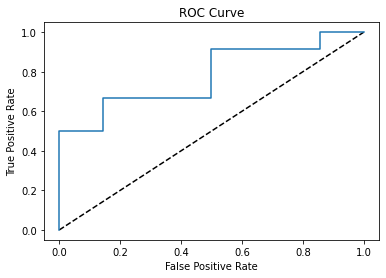

In [57]:
evaluate(rfc, X_train, X_test, y_train, y_test)

### The final model has a Train and Test score abve 90% for RECALL, which is a good result, even though the accuracy is in the 60% range. By shifting the scale to be centered around 0 instead of 3, we achieve normalization even better than standard scaler. Including the Average as an additonal feature makes sense as a visualization of the sum of all features, searching for an inflection point when the sum flips from Happy to Unhappy. In order to put that feature on the same scale, we divide by number of features which is taking the average. Feature importance was reviewed using different methods, but the incremental difference made it difficult to determine which feature or features to remove, because the model result is similar with various combinations. Not much time was spent on parameter tuning, because the incremental improvement is relatively small. Additonal methods such as RandomSearchCV instead of GridSearchCV, or hyperopt were considered, but not implemented due to time constraints.